# Examining simulation outputs

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import h5py
import healpy as hp

from drift.core import manager

[simons-mbp.dhcp.asu.edu:35053] shmem: mmap: an error occurred while determining whether or not /var/folders/m0/ght_x3x14xd7sksr0nknx03h0000gn/T//ompi.simons-mbp.501/jf.0/283639808/sm_segment.simons-mbp.501.10e80000.0 could be created.


# Sky maps

In [2]:
# cora map files can be accessed in 2 ways: by reading using the h5py library,
# or loading the entire file into memory as a "container", which is a class
# defined in draco that contains data and metadata for various output files
# we use in simulations and data analysis.

# Let's do the former, which tends to be useful for only loading part of a
# large dataset.
with h5py.File("sim_output/cora_maps/in_map_21cm.h5", "r") as f:
    # HDF5 file contents are similar to dicts, with keys that can either denote
    # datasets or collections (which themselves behave similar to dicts)

    print("Keys in file:", f.keys(), '\n')
    # 'index_map' contains the identities of various axes, while 'map' stores
    # the map data

    print("index_map contents:", f['index_map'].keys())
    print("map dataset", f['map'], '\n')

    # What are the axes of the map dataset?
    print("map axis definitions:", f['map'].attrs['axis'])

Keys in file: <KeysViewHDF5 ['index_map', 'map']> 

index_map contents: <KeysViewHDF5 ['freq', 'pixel', 'pol']>
map dataset <HDF5 dataset "map": shape (4, 4, 196608), type "<f8"> 

map axis definitions: ['freq' 'pol' 'pixel']


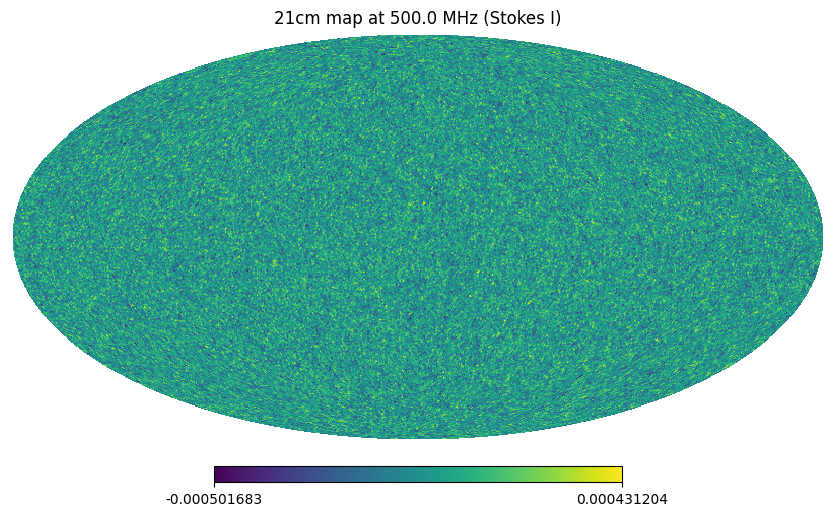

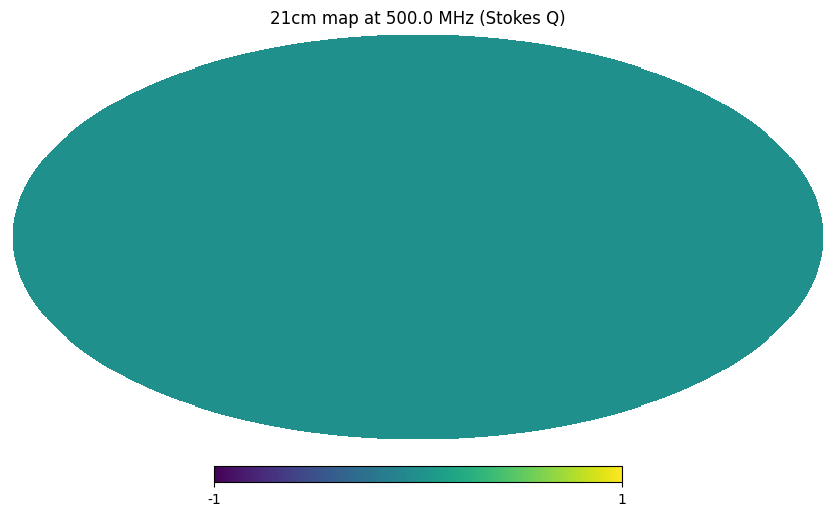

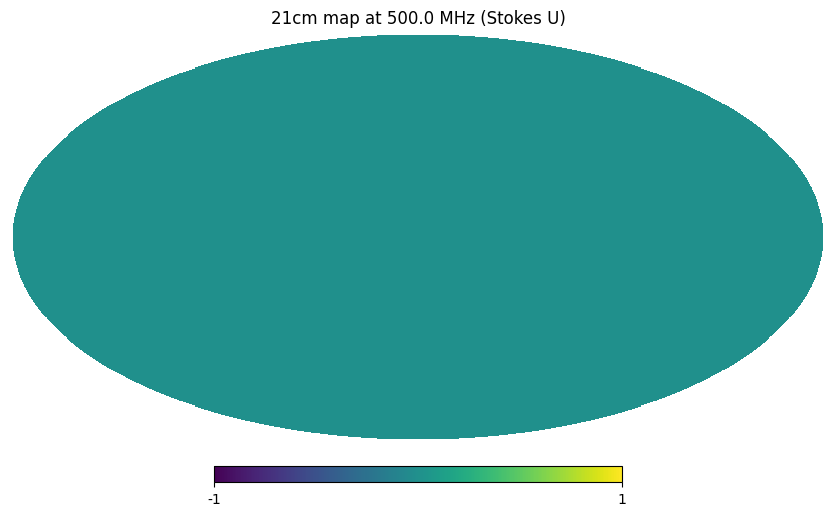

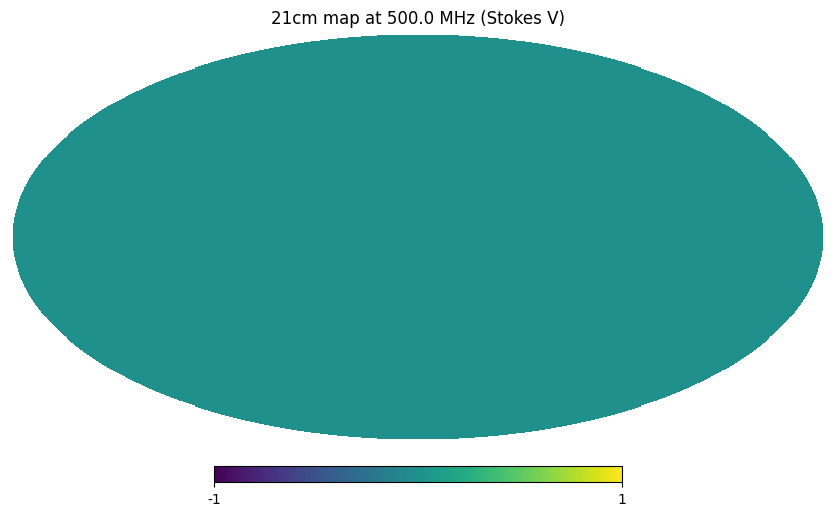

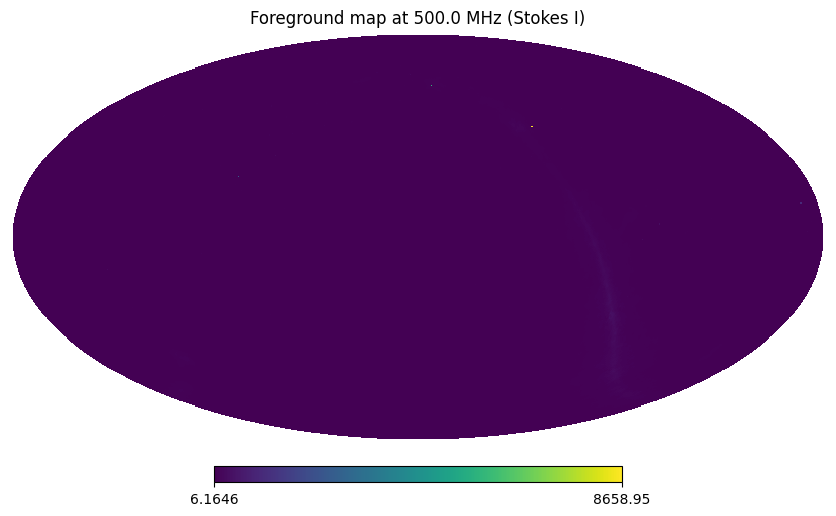

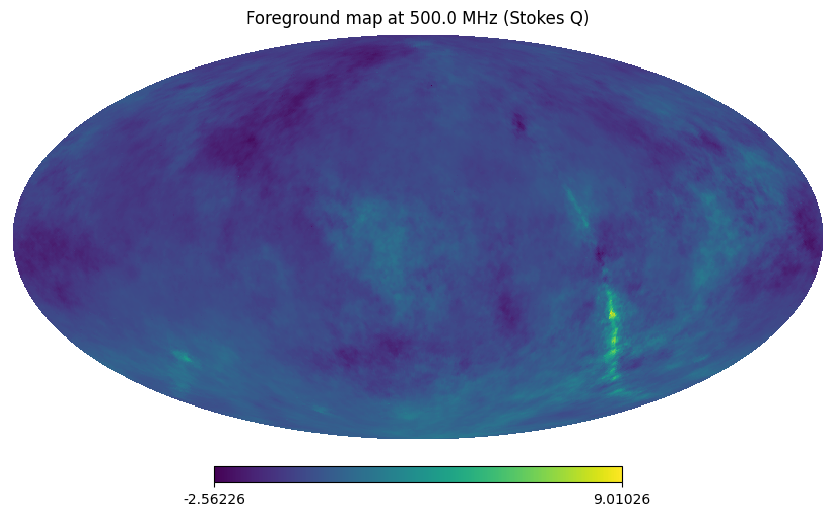

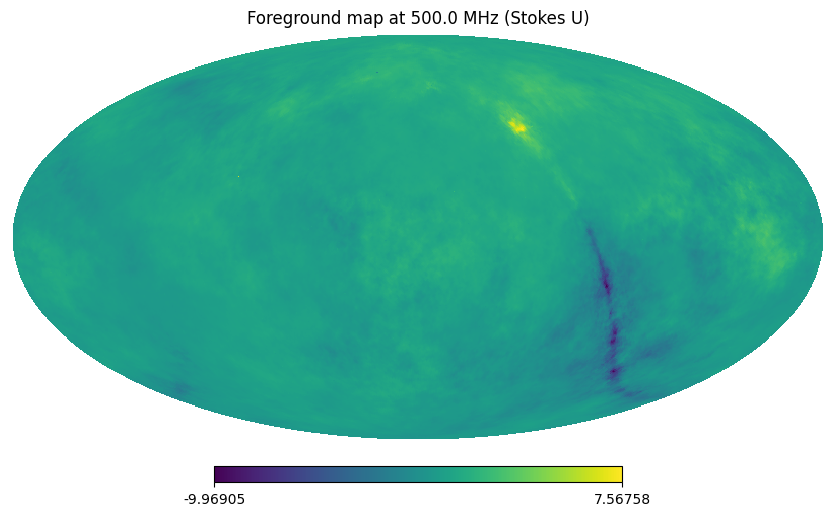

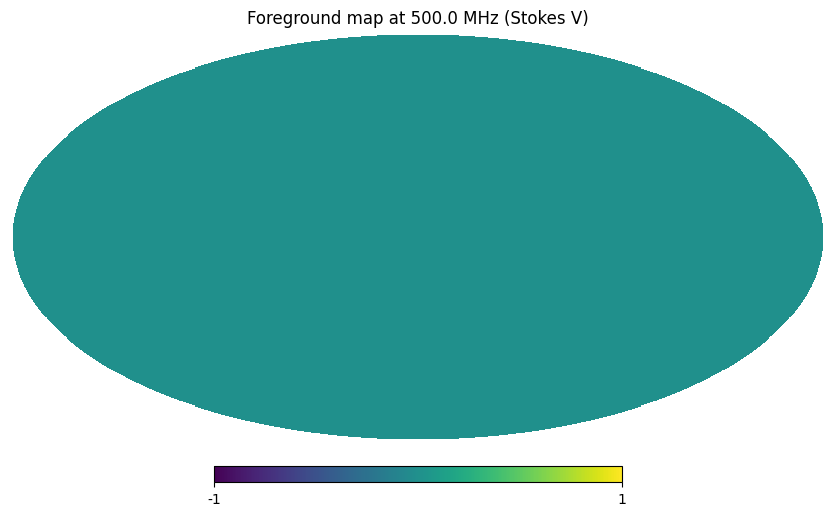

In [3]:
# Visualize our sky maps at a sample frequency
fi = 0

for fname, label in zip(["in_map_21cm.h5", "in_map_fg.h5"], ["21cm", "Foreground"]):

    with h5py.File(f"sim_output/cora_maps/{fname}", "r") as f:
        map_pol_axis = f['index_map/pol'][:]
        map_freq_axis = f['index_map/freq'][:]
    
        for pi, p in enumerate(map_pol_axis):
            hp.mollview(
                f['map'][fi, pi], 
                title=(
                    f"{label} map at {map_freq_axis[fi]['centre']} MHz "
                    f"(Stokes {map_pol_axis[pi].decode()})"
                )
            )

Some things to think about:
- Why do some of the above maps appear to be identically zero?
- Why does the foreground Stokes I map look mostly homogeneous, except for a few bright pixels? What happens if you adjust the color scale?
- Why do the foreground and 21cm maps look so different?

# Telescope object

In [4]:
# To access telescope properties and methods, we can load the telescope object
# via driftscan's ProductManager functionality:
tel_config = "sim_output/products/config.yaml"
chime_manager = manager.ProductManager.from_config(tel_config)
chime_telescope = chime_manager.telescope

In [5]:
# What frequencies are included?
print("Frequencies:", chime_telescope.frequencies)

Frequencies: [500.       499.609375 499.21875  498.828125]


In [6]:
# What baselines are included?
# The baselines are stored as [x component, y component],
# where x is EW and y is NS.
# In this simulation, we've only included a few baselines,
# but the full CHIME telescope would have 7155 entries here.
print("Baselines:\n", chime_telescope.baselines)

Baselines:
 [[ 0.00000000e+00  0.00000000e+00]
 [ 3.77703116e-04  3.04799766e-01]
 [ 3.77703116e-04  3.04799766e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 3.77703116e-04  3.04799766e-01]
 [ 3.77703116e-04  3.04799766e-01]
 [ 2.19999831e+01 -2.72620359e-02]
 [ 2.19996054e+01 -3.32061802e-01]
 [ 2.19999831e+01 -2.72620359e-02]
 [ 2.19996054e+01 -3.32061802e-01]
 [ 2.20003608e+01  2.77537730e-01]
 [ 2.20003608e+01  2.77537730e-01]
 [ 2.19999831e+01 -2.72620359e-02]
 [ 2.19996054e+01 -3.32061802e-01]
 [ 2.19999831e+01 -2.72620359e-02]
 [ 2.19996054e+01 -3.32061802e-01]
 [ 2.20003608e+01  2.77537730e-01]
 [ 2.20003608e+01  2.77537730e-01]]


In [7]:
# What are the positions of each feed within the telescope?
# These positions are defined with respect to an arbitrary
# point, and stored as [x,y].
# There are 2048 because we have 1024 antennas and each has
# 2 polarizations
print("Shape of feedpositions array:", chime_telescope.feedpositions.shape)
print("Some example feed positions:\n", chime_telescope.feedpositions[:10])

Shape of feedpositions array: (2048, 2)
Some example feed positions:
 [[-33.04813181 -38.82107711]
 [-33.04775411 -38.51627734]
 [-33.0473764  -38.21147758]
 [-33.0469987  -37.90667781]
 [-33.046621   -37.60187804]
 [-33.04624329 -37.29707828]
 [-33.04586559 -36.99227851]
 [-33.04548789 -36.68747875]
 [-33.04511019 -36.38267898]
 [-33.04473248 -36.07787921]]


In [8]:
# What's the polarization of each feed? We can look it up
# in chime_telescope.polarisation:
print("Feed polarizations:", chime_telescope.polarisation)

Feed polarizations: ['Y' 'Y' 'Y' ... 'X' 'X' 'X']


In [9]:
# What are all the possible pairs of the 2048 feeds?
# A list of pairs is stored in chime_telescope.index_map_prod:
print("index_map_prod dtype:", chime_telescope.index_map_prod.dtype)
print("index_map_prod:\n", chime_telescope.index_map_prod)

# There are N(N+1)/2 such pairs:
print(f"Length of index_map_prod:\t{len(chime_telescope.index_map_prod)}")
print(f"N(N+1)/2 for N=2048:\t\t{2048*2049/2}")

index_map_prod dtype: [('input_a', '<i8'), ('input_b', '<i8')]
index_map_prod:
 [(   0,    0) (   0,    1) (   0,    2) ... (2046, 2046) (2046, 2047)
 (2047, 2047)]
Length of index_map_prod:	2098176
N(N+1)/2 for N=2048:		2098176.0


In [10]:
# In CHIME, we mostly consider visibilities that have been averaged over
# redundant baselines. This means that a saved "visibility" will be an average
# of correlations over several pairs of feeds. In many data products, we
# don't store an explicit list of the feed pairs that went into each average.
# Instead, we store a "prodstack" array: for each baseline, prodstack tells 
# you one example of a pair of feeds that contributed to the average.
print("prodstack dtype:", chime_telescope.prodstack.dtype)
print("prodstack:\n", chime_telescope.prodstack)

prodstack dtype: [('input_a', '<i8'), ('input_b', '<i8')]
prodstack:
 [(  0,   0) (  1,   0) (  1, 256) (256,   0) (256, 256) (257,   0)
 (257, 256) (512,   0) (512,   1) (512, 256) (512, 257) (513,   0)
 (513, 256) (768,   0) (768,   1) (768, 256) (768, 257) (769,   0)
 (769, 256)]


In [11]:
# One useful application of prodstack is to figure out the polarizations
# that went into a given baseline:
baseline_pols = (
    chime_telescope.polarisation[chime_telescope.prodstack['input_a']] 
    + chime_telescope.polarisation[chime_telescope.prodstack['input_b']]
)

print("Baseline indices, polarizations, and baseline vectors:\n")
for i, (b, p) in enumerate(zip(chime_telescope.baselines, baseline_pols)):
    print(i, "\t\t ", p, "\t\t", b)

Baseline indices, polarizations, and baseline vectors:

0 		  YY 		 [0. 0.]
1 		  YY 		 [0.0003777  0.30479977]
2 		  YX 		 [0.0003777  0.30479977]
3 		  XY 		 [0. 0.]
4 		  XX 		 [0. 0.]
5 		  XY 		 [0.0003777  0.30479977]
6 		  XX 		 [0.0003777  0.30479977]
7 		  YY 		 [21.99998311 -0.02726204]
8 		  YY 		 [21.99960541 -0.3320618 ]
9 		  YX 		 [21.99998311 -0.02726204]
10 		  YX 		 [21.99960541 -0.3320618 ]
11 		  YY 		 [22.00036081  0.27753773]
12 		  YX 		 [22.00036081  0.27753773]
13 		  XY 		 [21.99998311 -0.02726204]
14 		  XY 		 [21.99960541 -0.3320618 ]
15 		  XX 		 [21.99998311 -0.02726204]
16 		  XX 		 [21.99960541 -0.3320618 ]
17 		  XY 		 [22.00036081  0.27753773]
18 		  XX 		 [22.00036081  0.27753773]


In [12]:
# Finally, if we want to find an index into index_map_prod for a representative
# feed pair for a given baseline, we can use the "prod" entry in index_map_stack.
print("index_map_stack dtype:", chime_telescope.index_map_stack.dtype)
print("index_map_stack:\n", chime_telescope.index_map_stack)

index_map_stack dtype: [('prod', '<u4'), ('conjugate', 'u1')]
index_map_stack:
 [(     0, 0) (     1, 1) (  2303, 0) (   256, 1) (491648, 0) (   257, 1)
 (491649, 1) (   512, 1) (  2559, 1) (491904, 1) (493695, 1) (   513, 1)
 (491905, 1) (   768, 1) (  2815, 1) (492160, 1) (493951, 1) (   769, 1)
 (492161, 1)]


In [13]:
# What about the "conjugate" entry in index_map_stack?
# Recall that a visibility is a product of a signal from feed i, F_i,
# and the complex conjugate of a signal from feed j, F_j^*.
# CHIME has specific conventions for which feeds in a given pair should
# be assigned to i and j in this equation, based on the relative locations
# of the antennas in the array.
# The feed ordering in prodstack incorporates this convention, but
# the feed ordering in index_map_prod does not, so in some cases, we need
# to apply a conjugation ourselves to remain consistent with the CHIME
# convention.
# If conjugate == 1 and we use index_map_stack to find a feed pair in
# index_map_prod, we'll need to apply an extra complex conjugation to
# convert to CHIME conventions. If conjugate == 0, this is not necessary.

# We can see then by comparing entries in prodstack and entries in
# index_map_prod that are retrieved from index_map_stack: if conjugate==1,
# the two entries are reversed.
print("prodstack entry\t\tprod entry from stack\t\tconjugate entry from stack")
for i, (ps, p, c) in enumerate(
    zip(
        chime_telescope.prodstack, 
        chime_telescope.index_map_prod[chime_telescope.index_map_stack['prod']],
        chime_telescope.index_map_stack['conjugate']
    )
):
    print(ps, '\t\t\t', p, '\t\t\t', c)

prodstack entry		prod entry from stack		conjugate entry from stack
(0, 0) 			 (0, 0) 			 0
(1, 0) 			 (0, 1) 			 1
(1, 256) 			 (1, 256) 			 0
(256, 0) 			 (0, 256) 			 1
(256, 256) 			 (256, 256) 			 0
(257, 0) 			 (0, 257) 			 1
(257, 256) 			 (256, 257) 			 1
(512, 0) 			 (0, 512) 			 1
(512, 1) 			 (1, 512) 			 1
(512, 256) 			 (256, 512) 			 1
(512, 257) 			 (257, 512) 			 1
(513, 0) 			 (0, 513) 			 1
(513, 256) 			 (256, 513) 			 1
(768, 0) 			 (0, 768) 			 1
(768, 1) 			 (1, 768) 			 1
(768, 256) 			 (256, 768) 			 1
(768, 257) 			 (257, 768) 			 1
(769, 0) 			 (0, 769) 			 1
(769, 256) 			 (256, 769) 			 1


# Beam transfer matrices

If you're unfamiliar with the m-mode formalism, see Sec. I-II of https://arxiv.org/abs/1401.2095.

In [14]:
# The product manager contains an instance of the BeamTransfer class, which can
# be used to load saved beam transfer matrices from disk by specifying an m
# and optionally a frequency index:
m_test = 50
btm_test = chime_manager.beamtransfer.beam_m(m_test)

# For a larger simulation, these files might be huge, but in this small simulation
# we can just load the whole thing.

# Each BTM is saved with shape (nfreq, 2, npairs, npol_sky, lmax+1), where:
#  - nfreq = number of frequencies
#  - 2 = sign of m (postive-m and negative-m BTMs are stored in the same file)
#  - npairs = number of baselines
#  - npol_sky = number of Stokes parameters for the sky signal
#  - lmax+1 = number of spherical harmonic ell values
print("BTM array shape:", btm_test.shape)

BTM array shape: (4, 2, 19, 4, 443)


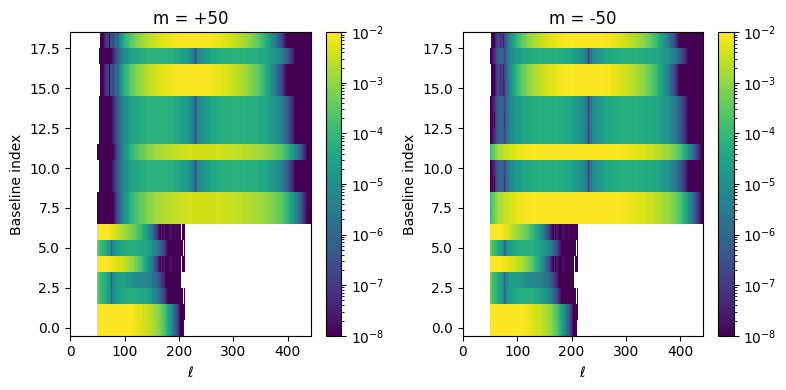

In [15]:
# Plot BTMs at a sample frequency and for Stokes I
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i in range(2):
    im = ax[i].imshow(
        np.abs(btm_test[0,i,:,0]), 
        aspect='auto', 
        origin='lower', 
        interpolation='none', 
        norm=LogNorm(),
        clim=[1e-8, 1e-2]
    )

    ax[i].set_title(f"m = {'+' if i == 0 else '-'}{m_test}")
    fig.colorbar(im, ax=ax[i], orientation='vertical')

    ax[i].set_xlabel(r"$\ell$")
    ax[i].set_ylabel("Baseline index")

plt.tight_layout()

Some things to think about:
- What causes the horizontal striping structure in these plots?
- What causes the white regions?
- Why does the size of the BTM elements drop off at higher $\ell$? At lower $\ell$?

# Visibilities

In [16]:
# Visibilities are also stored in HDF5 files:
with h5py.File("sim_output/streams/stream_21cm.h5", "r") as f:
    print("Keys in file:", f.keys(), '\n')

    # 'vis' contains the visibilities, while 'vis_weight' contains weights
    # related to data quality and noise. (In this simulation, the weights
    # are not set realistically, but in real data, they are based on
    # noise estimates for each time/freq sample)
    print("vis dataset:", f['vis'])
    print("vis dataset axes:", f['vis'].attrs['axis'], '\n')
    print("vis_weight dataset:", f['vis_weight'])
    print("vis_weight dataset axes:", f['vis_weight'].attrs['axis'], '\n')
    
    # The 'stack' index indexes baseline/polarization, and has the same format
    # as chime_telescope.index_map_stack:
    print("stack axis:\n", f['index_map/stack'][:])
    print("stack axis dtype:\n", f['index_map/stack'].dtype, '\n')

    # The 'ra' axis is a time axis. Time is represented by the right ascension
    # that coincides with the telescope's local meridian.
    print("part of ra axis:\n", f['index_map/ra'][:20])

Keys in file: <KeysViewHDF5 ['history', 'index_map', 'input_flags', 'reverse_map', 'vis', 'vis_weight']> 

vis dataset: <HDF5 dataset "vis": shape (4, 19, 883), type "<c8">
vis dataset axes: ['freq' 'stack' 'ra'] 

vis_weight dataset: <HDF5 dataset "vis_weight": shape (4, 19, 883), type "<f4">
vis_weight dataset axes: ['freq' 'stack' 'ra'] 

stack axis:
 [(     0, 0) (     1, 1) (  2303, 0) (   256, 1) (491648, 0) (   257, 1)
 (491649, 1) (   512, 1) (  2559, 1) (491904, 1) (493695, 1) (   513, 1)
 (491905, 1) (   768, 1) (  2815, 1) (492160, 1) (493951, 1) (   769, 1)
 (492161, 1)]
stack axis dtype:
 [('prod', '<u4'), ('conjugate', 'u1')] 

part of ra axis:
 [0.         0.40770102 0.81540204 1.22310306 1.63080408 2.0385051
 2.44620612 2.85390713 3.26160815 3.66930917 4.07701019 4.48471121
 4.89241223 5.30011325 5.70781427 6.11551529 6.52321631 6.93091733
 7.33861835 7.74631937]


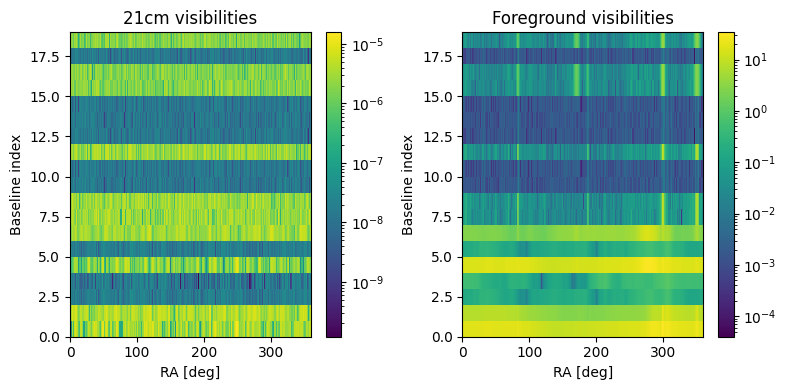

In [17]:
# Plot visibilities at a sample frequency
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i, (fname, label) in enumerate(zip(["stream_21cm.h5", "stream_fg.h5"], ["21cm", "Foreground"])):
    with h5py.File(f"sim_output/streams/{fname}", "r") as f:
        im = ax[i].imshow(
            np.abs(f['vis'][0]), 
            aspect='auto', 
            origin='lower', 
            interpolation='none', 
            norm=LogNorm(),
            # clim=[1e-9, 1e-5], 
            extent=[f['index_map/ra'][0], f['index_map/ra'][-1], 0, len(f['index_map/stack'])]
        )
    
        ax[i].set_title(f"{label} visibilities")
        fig.colorbar(im, ax=ax[i], orientation='vertical')
        
        ax[i].set_xlabel("RA [deg]")
        ax[i].set_ylabel("Baseline index")

plt.tight_layout()

Some things to think about:
- What causes the horizontal striping structure in these plots?
- In the foreground panel, why are some of the lower stripes so much brighter than the upper stripes?
- In the foreground panel, what causes the 4 bright vertical stripes that are visible in the upper ~half of the plot?
- In the foreground panel, what causes the 5th bright vertical strip in the upper few baselines?